# Travel Insurance Prediction

For this analysis Kagle data set [Travel Insurance](https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data) is used.

Here is data set description from the Kagle:

*A Tour & Travels Company is offering Travel Insurance Package to their customers. The new Insurance Package also includes Covid cover. The company requires to know which customers would be interested to buy it based on its database history. The Insurance was offered to **some** of the customers in 2019 and the given data has been extracted from the performance / sales of the package during that period. The data is provided for almost 2000 of its previous customers and there is a requirement to build an intelligent model that can predict if the customer will be interested to buy the travel insurance package based on certain parameters.*

## Project Goal

The goal of this project is create a model which could suggest which customer would be interested to buy Travel Insurance Package.

## 0. Dataset Overview

Dataset has 8 independent variables:
1. **Age** - age of the customer
2. **Employment Type** - the sector in which customer is employed
3. **GraduateOrNot** - whether the customer is college graduate or not
4. **AnnualIncome** - the yearly income of the customer in Indian Rupees (rounded to nearest 50 thousand Rupees)
5. **FamilyMembers** - number of members in customer's family
6. **ChronicDisease** - whether the customer suffers from any major disease or conditions like Diabetes/High BP or Asthama,etc.
7. **FrequentFlyer** - derived data based on customer's history of booking air tickets in at least 4 different instances in the last 2 years [2017-2019].
8. **EverTravelledAbroad** - has the customer ever travelled to a foreign country (not necessarily using the Company's services)

and 1 dependent variable:

9. **TravelInsurance** - did the customer buy Travel Insurance Package during introductory offering held in the year 2019.

For initial dataset overview 
- sample size
- nulls
- data types
- duplicates

will be checked. Outliers will be analysed in EDA part.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from scipy.stats import ttest_ind, levene, shapiro
import statsmodels.stats.api as sms
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest
import textwrap
import phik
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("TravelInsurancePrediction.csv", index_col=0)
df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [3]:
print(df.info(), end="\n\n")
print("Dataset has", df.shape[0], "observations and", df.shape[1], "features.")
print(
    "Dataset has",
    df.duplicated().sum(),
    "duplicated observations,",
    (df.duplicated().sum() / df.shape[0] * 100).round(2),
    "%.",
)

<class 'pandas.core.frame.DataFrame'>
Index: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1987 non-null   int64 
 1   Employment Type      1987 non-null   object
 2   GraduateOrNot        1987 non-null   object
 3   AnnualIncome         1987 non-null   int64 
 4   FamilyMembers        1987 non-null   int64 
 5   ChronicDiseases      1987 non-null   int64 
 6   FrequentFlyer        1987 non-null   object
 7   EverTravelledAbroad  1987 non-null   object
 8   TravelInsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 155.2+ KB
None

Dataset has 1987 observations and 9 features.
Dataset has 738 duplicated observations, 37.14 %.


### Overview Summary

- Dataset has 1987 observations and 9 features. 8 of them independent variables, and 1 `TravelInsurance` - dependent.
- There is no null values in the dataset.
- Dataset has quite big part of duplicates ~ 37 %. This will be investigated separately in EDA.
- Some features like `GraduateOrNot`, `ChronicDiseases`, `FrequentFlyer`, `EverTravelledAbroad`, `TravelInsurance` are simple *Yes & No* type of questions however answers are recorded in different way.

## 1. Exploratory Data Analysis

### 1.1. Duplicates

In [4]:
df[df.duplicated()].head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
69,31,Government Sector,No,300000,4,0,No,No,0
103,26,Private Sector/Self Employed,Yes,1400000,5,0,No,Yes,1
117,31,Government Sector,Yes,400000,5,0,No,No,0
148,25,Private Sector/Self Employed,Yes,1400000,4,0,No,Yes,1
164,28,Government Sector,Yes,300000,6,0,No,No,0


In [5]:
print("Full duplicates:", len(df[df.duplicated()]))
print(
    "Almost duplicates - without 'Travel Insurance':",
    len(df[df.drop("TravelInsurance", axis=1).duplicated()]),
)

Full duplicates: 738
Almost duplicates - without 'Travel Insurance': 885


Dataset has more than 37% of duplicated records. Potential reasons for than can be:

- Structure of the dataset. Most features here have just binary outcome what significantly reduces possible combinations.
- Potentially continuos features `Age`, and `AnnualIncome` look continues just from the first glance, as `Age` is limited in range of 25-35 and `AnnualIncome` is rounded to nearest 50 k.
- `Employment type` feature has 2 possible answers so may be called binary as well.
- There are even more **Almost duplicates** what means that with the same values in independent features there is different outcome for `Travel Insurance`. This signals that dataset is missing some important information which has influence on decision.

Further will be checked how frequent duplicates are.

In [6]:
duplicates_count = df.groupby(df.columns.tolist()).size().reset_index(name="Count")
duplicates_count.sort_values("Count", ascending=False).head(7)

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,Count
280,28,Government Sector,Yes,300000,4,0,No,No,0,12
646,29,Private Sector/Self Employed,Yes,1200000,4,0,No,No,0,11
423,28,Private Sector/Self Employed,Yes,800000,4,0,No,No,0,10
284,28,Government Sector,Yes,300000,5,0,No,No,0,10
462,28,Private Sector/Self Employed,Yes,1100000,4,0,No,No,0,8
1145,34,Private Sector/Self Employed,Yes,1000000,5,0,No,No,0,7
286,28,Government Sector,Yes,300000,6,0,No,No,0,7


In [7]:
fig = px.histogram(
    duplicates_count[duplicates_count["Count"] > 1],
    x="Count",
    color="TravelInsurance",
    barmode="group",
    category_orders={"TravelInsurance": [1, 0]},
    text_auto=True,
    height=300,
    title="Duplicates count",
    labels={"Count": "How many times it was repeated?"},
)

fig.update_layout(
    yaxis_title="Count of different records", legend_title="Travel Insurance"
)
fig.update_xaxes(dtick=1)

fig.show()

In [8]:
print(
    "Different values for: \nAge -",
    len(df["Age"].value_counts()),
    "\nAnnual Income -",
    len(df["AnnualIncome"].value_counts()),
    "\nFamily Members",
    len(df["FamilyMembers"].value_counts()),
)

Different values for: 
Age - 11 
Annual Income - 30 
Family Members 8


Results show that majority of duplicates were repeated couple times. Having in mind nature of the dataset and limited number of features and their binary answers (6 features having 2 answers results: $2^6 = 64$ possible combinations) this is expected.

Important here is decition either to keep duplicates or to remove them. 

Arguments for removing: 

- Duplicated values do not add additional information to dataset.
- Duplicates influence Machine Learning models to learn and remember those specific patterns rather than actually generalizing Models.

Arguments for keeping:

- When looking at **Almost duplicates** (everything is the same except `Travel Insurance` value) frequency of customers who bought vs. did not buy **Travel Insurane** is not the same. Removal of duplicates will even those frequencies. When frequencies are equal - Model will not be able to classify.
- Limited number of features, the fact that majority of them are binary, and rounded continues features makes duplicates very possible.
- In real life situations there is no guarantee that data will not have duplicates.

In [9]:
dff = df.drop("TravelInsurance", axis=1)
dff.drop_duplicates(keep=False, inplace=True)
print("Number of measurements after duplicates cleanup:", dff.shape[0])

Number of measurements after duplicates cleanup: 687


In real life scenario to avoid any information leakage all **Almost duplicates** should be removed, in case there is 50-50 split in **Travel Insurance** values. In cases when split is not 50-50, more possible option could be kept. However removing all **Almost duplicates** dataset will decrease drastically, with remainins only 687 measurements. Such number of data may be insufficient for proper Model training and testing. This signals dataset limitation, and need for additional features for proper model creation.

Having this in mind - only full duplicates will be removed. This will be done after Train - Test split and only for Train set. Reason for this is that in real life scenarion there is no guarantee that new data which is coming in, will not have duplicates.

### 1.2. Dataset split

Dataset will be split up to training and test data sets. During split stratification will be done by dependent variable `Travel Insurance`.

Duplicated rows will be cleaned from Train part.

In [10]:
RandomState = 198
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=RandomState, stratify=df["TravelInsurance"]
)


df_train_original = df_train.copy(deep=True)  # Original copy with duplicates
df_train.drop_duplicates(keep="first", inplace=True)
df_train_eda = df_train.copy(deep=True)  # Copy for EDA part


X_train = df_train.drop(columns=["TravelInsurance"]).reset_index(drop=True)
y_train = df_train["TravelInsurance"].reset_index(drop=True)


X_test = df_test.drop(columns=["TravelInsurance"])
y_test = df_test["TravelInsurance"]

Some data in EDA dataset will be unified for easier analysis

In [11]:
df_train_eda[["GraduateOrNot", "FrequentFlyer", "EverTravelledAbroad"]] = df_train_eda[
    ["GraduateOrNot", "FrequentFlyer", "EverTravelledAbroad"]
].map(lambda x: 1 if x == "Yes" else 0 if x == "No" else x)

df_train_eda["Employment Type"] = df_train_eda["Employment Type"].map(
    lambda x: 1 if x == "Government Sector" else 0
)

df_train_eda = df_train_eda.rename(
    columns={
        "GraduateOrNot": "Graduate or not",
        "AnnualIncome": "Annual Income",
        "FamilyMembers": "Family Members",
        "ChronicDiseases": "Chronic Diseases",
        "FrequentFlyer": "Frequent Flyer",
        "EverTravelledAbroad": "Ever Travelled Abroad",
        "TravelInsurance": "Travel Insurance",
        "Employment Type": "Employment Government Sector",
    }
)

### 1.3. Dependent variable **Travel Insurance**

In [12]:
print(
    "Travel Insurance order rate is:",
    (
        (df_train["TravelInsurance"].sum() / len(df_train["TravelInsurance"])) * 100
    ).round(2),
    "%",
)

Travel Insurance order rate is: 38.46 %


**Travel Insurance** is binary variable with outcome 1 - Yes, and 0 - No. From dataset it is clear that ~ 1/3 of customers bought **Travel Insurance**. 

### 1.4. Independent Numerical variables

Function will be created for consistent visualisation and overview.

In [13]:
def numerical_overview_plot(df, x, n=0):
    """
    Generates a histogram with a box plot to visualize the distribution of a numerical column,
    categorized by target variablen, and displays summary statistics.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the data.
        x (str): The name of the numerical column to visualize.
        n (int): Number to which rounding has to be done.

    Returns:
        None: Displays the plots and prints descriptive statistics for the specified column.
    """
    fig1 = px.histogram(
        df,
        x=x,
        y="Travel Insurance",
        marginal="box",
        histfunc="count",
        color="Travel Insurance",
        category_orders={"Travel Insurance": [1, 0]},
        title=f"Distribution of <b>{x}</b>",
        text_auto=True,
        height=350,
        labels={x: ""},
    )

    fig1.update_layout(xaxis=dict(range=[df[x].min() - 0.5, df[x].max() + 0.5]))
    fig1.add_vline(x=df[x].mean(), line_dash="dash", line_color="black")
    fig1.add_annotation(
        x=df[x].mean(),
        y=1.1,
        yref="paper",
        text=f"Mean: {df[x].mean():.2f}",
        showarrow=False,
    )

    fig2 = px.histogram(
        df,
        x=x,
        y="Travel Insurance",
        histfunc="count",
        color="Travel Insurance",
        category_orders={"Travel Insurance": [1, 0]},
        barnorm="percent",
        text_auto=".0f",
        height=350,
        labels={x: ""},
    )

    fig2.update_traces(textangle=0)
    fig2.update_layout(
        yaxis_title="Percent",
        xaxis=dict(range=[df[x].min() - 0.5, df[x].max() + 0.5]),
        yaxis=dict(range=[0, 110]),
    )

    if n > 0:
        fig1.update_xaxes(dtick=1)
        fig2.update_xaxes(dtick=1)

    fig1.show()
    fig2.show()

    overall_stats = df[x].describe().to_frame().T.round(n)
    overall_stats.index = ["All"]
    group_stats = df.groupby("Travel Insurance")[x].describe().round(n)

    combined_stats = pd.concat([overall_stats, group_stats])
    combined_stats.rename(columns={"index": "Group"}, inplace=True)

    print(f"{x} descriptive statistics by Travel Insurance\n")
    print(combined_stats.to_string(index=True))

#### 1.4.1. **Age**

In [14]:
numerical_overview_plot(df_train_eda, "Age", 2)

Age descriptive statistics by Travel Insurance

      count   mean   std   min   25%   50%   75%   max
All  1079.0  29.73  2.93  25.0  28.0  29.0  32.0  35.0
0     664.0  29.55  2.71  25.0  28.0  29.0  32.0  35.0
1     415.0  30.02  3.23  25.0  28.0  30.0  33.0  35.0


- **Age** has values 25-35 what rise question if the clients of this company are only with this **Age** range, or the experiment with offer was only for this **Age** group.
- **Age** distribution shows peak in Age=28 what makes dataset a bit imbalanced.
- Percentage show that younger group Age: 25-26 and older group Age: 33-35 have higher rate of taking **Travel Insurance**. 
- Average **Age** for **Travel Insurance** groups differ, however difference do not seem like a big one. Significance of this difference will be checked with test.
- There are no outliers for **Age** variable.

##### Hypothesis testing

**Age** average $\mu_0$ and $\mu_1$ for **Travel Insurance** groups 0 and 1 will be compared to see if there is a statistically significant difference with $\alpha=0.05$.

$H_0: \mu_0 - \mu_1 = 0$ 

$H_A: \mu_0 - \mu_1 \neq 0$

- As groups size is relatively high (>30) - Central Limit Theorem takes place, so distributions don't have to be Normal, however this still be checked with Shapiro test.
- Homogeneity will be checked with Levene's test. 
- As groups are unbalanced, for mean comparison - Welsh's t-test will be used. 

Functions will be created for consistent test results.

In [15]:
def shapiro_test(group):
    """
    Performs the Shapiro-Wilk test for normality on a dataset and prints the results.

    Parameters:
        group (array-like): The dataset to be tested for normality.

    Returns:
        None: Prints whether the data is normally distributed based on the test's p-value.
    """
    stat_group, p_group = shapiro(group)
    if p_group < 0.05:
        print(
            f"Shapiro-Wilk Test. Statistic: {stat_group:.4f}, p-value: {p_group:.4f}. Data is not normally distributed."
        )
    else:
        print(
            f"Shapiro-Wilk Test. Statistic: {stat_group:.4f}, p-value: {p_group:.4f}. Data is normally distributed."
        )

In [16]:
def levene_test(group0, group1, cnt="mean"):
    """
    Performs Levene's test for equality of variances between two groups.

    Parameters:
        group0 (array-like): First dataset for comparison.
        group1 (array-like): Second dataset for comparison.
        cnt (str): Specifies the measure of central tendency for Levene's test.
                   Options are "mean" (default), "median", or "trimmed".

    Returns:
        None: Prints whether the variances are significantly different based on the test's p-value.
    """
    lev_stat, lev_p_value = levene(group0, group1, center=cnt)

    if lev_p_value < 0.05:
        print(
            f"Levene's statistic: {lev_stat:.4f}, p-value: {lev_p_value:.4f}. Variances are significantly different."
        )
    else:
        print(
            f"Levene's statistic: {lev_stat:.4f}, p-value: {lev_p_value:.4f}. Variances are not significantly different."
        )

In [17]:
def welch_test(group0, group1, variance=False):
    """
    Performs Welch's t-test to compare the means of two independent groups and calculates the mean difference
    with its confidence interval.

    Parameters:
        group0 (array-like): First dataset for comparison.
        group1 (array-like): Second dataset for comparison.
        variance (bool): If False (default), performs Welch's t-test assuming unequal variances.
                         If True, performs a standard t-test assuming equal variances.

    Returns:
        None: Prints the t-statistic, p-value, mean difference, and 95% confidence interval for the difference in means.
    """
    t_stat, p_value = ttest_ind(group0, group1, equal_var=variance)
    mean_diff = np.mean(group0) - np.mean(group1)
    cm = sms.CompareMeans(sms.DescrStatsW(group0), sms.DescrStatsW(group1))
    ci_low, ci_high = cm.tconfint_diff(usevar="unequal")  # 'unequal' for Welch's t-test

    print(f"Welch's t-test Results. t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("There is significant difference in means between the two groups.")
    else:
        print("There is no significant difference in means between the two groups.")

    print(
        f"Mean Difference: {mean_diff:.2f}, 95% Confidence Interval: ({ci_low:.2f}, {ci_high:.2f})"
    )

##### Test results for **Age**.

In [18]:
print("Travel Insurance = 1")
shapiro_test(df_train_eda[df_train_eda["Travel Insurance"] == 1]["Age"])
print("Travel Insurance = 0")
shapiro_test(df_train_eda[df_train_eda["Travel Insurance"] == 0]["Age"])

Travel Insurance = 1
Shapiro-Wilk Test. Statistic: 0.9135, p-value: 0.0000. Data is not normally distributed.
Travel Insurance = 0
Shapiro-Wilk Test. Statistic: 0.9328, p-value: 0.0000. Data is not normally distributed.


In [19]:
levene_test(
    df_train_eda[df_train_eda["Travel Insurance"] == 1]["Age"],
    df_train_eda[df_train_eda["Travel Insurance"] == 0]["Age"],
    "median",
)

Levene's statistic: 43.9033, p-value: 0.0000. Variances are significantly different.


In [20]:
welch_test(
    df_train_eda[df_train_eda["Travel Insurance"] == 1]["Age"],
    df_train_eda[df_train_eda["Travel Insurance"] == 0]["Age"],
)

Welch's t-test Results. t-statistic: 2.4387, p-value: 0.0150
There is significant difference in means between the two groups.
Mean Difference: 0.46, 95% Confidence Interval: (0.09, 0.84)


Test results show that average **Age** of customers who bought **Travel Insurance** versus the ones who didn't differ by 0.46 year, and this difference is statistically significant.

#### 1.4.2. **Annual Income**

In [21]:
numerical_overview_plot(df_train_eda, "Annual Income")

Annual Income descriptive statistics by Travel Insurance

      count       mean       std       min       25%        50%        75%        max
All  1079.0   929657.0  358466.0  300000.0  600000.0   900000.0  1200000.0  1800000.0
0     664.0   846160.0  320322.0  300000.0  600000.0   800000.0  1100000.0  1750000.0
1     415.0  1063253.0  375767.0  300000.0  750000.0  1100000.0  1400000.0  1800000.0


- **Annual Income** distribution is relatively even.
- There is a difference in average **Annual Income** for **Travel Insurance** goups. Mean difference will be checked with tests.
- There is tendency that customers with higher **Annual Income** tend to buy **Travel Insurance** more. 
- There are some **Annual Income** values which are on the upper outlier limit, bet it is still within the Q3 + 1,5 IQR range.

##### Hypothesis testing

**Annual Income** average $\mu_0$ and $\mu_1$ for **Travel Insurance** groups 0 and 1 will be compared to see if there is a statistically significant difference with $\alpha=0.05$.

$H_0: \mu_0 - \mu_1 = 0$

$H_A: \mu_0 - \mu_1 \neq 0$

##### Test results for **Annual Income**

In [22]:
print("Travel Insurance = 1")
shapiro_test(df_train_eda[df_train_eda["Travel Insurance"] == 1]["Annual Income"])
print("Travel Insurance = 0")
shapiro_test(df_train_eda[df_train_eda["Travel Insurance"] == 0]["Annual Income"])

Travel Insurance = 1
Shapiro-Wilk Test. Statistic: 0.9446, p-value: 0.0000. Data is not normally distributed.
Travel Insurance = 0
Shapiro-Wilk Test. Statistic: 0.9671, p-value: 0.0000. Data is not normally distributed.


In [23]:
levene_test(
    df_train_eda[df_train_eda["Travel Insurance"] == 1]["Annual Income"],
    df_train_eda[df_train_eda["Travel Insurance"] == 0]["Annual Income"],
    "median",
)

Levene's statistic: 25.1181, p-value: 0.0000. Variances are significantly different.


In [24]:
welch_test(
    df_train_eda[df_train_eda["Travel Insurance"] == 1]["Annual Income"],
    df_train_eda[df_train_eda["Travel Insurance"] == 0]["Annual Income"],
)

Welch's t-test Results. t-statistic: 9.7599, p-value: 0.0000
There is significant difference in means between the two groups.
Mean Difference: 217093.37, 95% Confidence Interval: (173428.93, 260757.82)


Test results show that average **Annual Income** of customers who bought **Travel Insurance** versus the ones who didn't differ by ~217093 Indian Rupees, and this difference is statistically significant.

#### 1.4.3. **Family Members**

In [25]:
numerical_overview_plot(df_train_eda, "Family Members", 2)

Family Members descriptive statistics by Travel Insurance

      count  mean   std  min  25%  50%  75%  max
All  1079.0  4.88  1.76  2.0  4.0  5.0  6.0  9.0
0     664.0  4.75  1.73  2.0  3.0  5.0  6.0  9.0
1     415.0  5.08  1.79  2.0  4.0  5.0  6.0  9.0


- Distribution of **Family Members** looks close to Normal with highest frequency at **4** with right skeweness.
- Average **Family Members** numbers are very similar for both **Travel Insurance** groups. Difference in means will be checked with tests.
- Percent of customers who bought **Travel Insurance** compared to the ones who didn't looks similar with slight increase for higher **Family Member** numbers.

##### Hypothesis testing

**Family Members** average $\mu_0$ and $\mu_1$ for **Travel Insurance** groups 0 and 1 will be compared to see if there is a statistically significant difference with $\alpha=0.05$.

$H_0: \mu_0 - \mu_1 = 0$

$H_A: \mu_0 - \mu_1 \neq 0$

##### Test results for **Family Members**

In [26]:
print("Travel Insurance = 1")
shapiro_test(df_train_eda[df_train_eda["Travel Insurance"] == 1]["Family Members"])
print("Travel Insurance = 0")
shapiro_test(df_train_eda[df_train_eda["Travel Insurance"] == 0]["Family Members"])

Travel Insurance = 1
Shapiro-Wilk Test. Statistic: 0.9468, p-value: 0.0000. Data is not normally distributed.
Travel Insurance = 0
Shapiro-Wilk Test. Statistic: 0.9405, p-value: 0.0000. Data is not normally distributed.


In [27]:
levene_test(
    df_train_eda[df_train_eda["Travel Insurance"] == 1]["Family Members"],
    df_train_eda[df_train_eda["Travel Insurance"] == 0]["Family Members"],
    "median",
)

Levene's statistic: 0.9031, p-value: 0.3422. Variances are not significantly different.


In [28]:
welch_test(
    df_train_eda[df_train_eda["Travel Insurance"] == 1]["Family Members"],
    df_train_eda[df_train_eda["Travel Insurance"] == 0]["Family Members"],
)

Welch's t-test Results. t-statistic: 2.9923, p-value: 0.0028
There is significant difference in means between the two groups.
Mean Difference: 0.33, 95% Confidence Interval: (0.11, 0.55)


Test results show that average **Family Members** of customers who bought **Travel Insurance** versus the ones who didn't differ by 0.33, and this difference is statistically significant.

### 1.5. Independent Categorical variables

In [29]:
df_melted = df_train_eda[
    [
        "Graduate or not",
        "Chronic Diseases",
        "Frequent Flyer",
        "Ever Travelled Abroad",
        "Employment Government Sector",
        "Travel Insurance",
    ]
].melt(var_name="Feature", value_name="answ", id_vars="Travel Insurance")

df_melted["answ"] = df_melted["answ"].apply(lambda x: "Yes" if x == 1 else "No")
df_melted["Travel Insurance"] = pd.Categorical(
    df_melted["Travel Insurance"], categories=[1, 0], ordered=True
)
df_melted["answ"] = pd.Categorical(
    df_melted["answ"], categories=["Yes", "No"], ordered=True
)

In [30]:
fig1 = px.histogram(
    df_melted,
    x="answ",
    y="Travel Insurance",
    facet_col="Feature",
    color="Travel Insurance",
    text_auto=True,
    category_orders={"Travel Insurance": [1, 0]},
    barmode="group",
    labels={"answ": ""},
    height=300,
    histfunc="count",
    title="",
)

fig2 = px.histogram(
    df_melted,
    x="answ",
    y="Travel Insurance",
    facet_col="Feature",
    color="Travel Insurance",
    text_auto=".0f",
    category_orders={"Travel Insurance": [1, 0]},
    barmode="group",
    labels={"answ": ""},
    height=300,
    barnorm="percent",
    histfunc="count",
)

fig2.update_layout(yaxis_title="Percent")

fig1.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
fig2.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))

fig1.show()
fig2.show()

- From absolute numbers it is visible that more customers do not buy **Travel Insurance** except for **Frequent Flyer** and the ones who **Ever Travelled Abroad**.
- From percent point of view, situation is different.
    - For **Graduate or not** and **Chronic Diseases** rate of customer who bought **Travel Insurance** is similar in both groups. At the same time, it is similar to overall rate of customer who bought **Travel Insurance**. It may mean that wilingness to buy **Travel Insurance** does not depend on **Graduation** or **Chronic Diseases** status.
    - For **Frequent Flyer** and **Ever Travelled Abroad** rate for customer who bought **Travel Insurance** is higher if previous question was answered **Yes**. 
    - For **Employment Government Sector** rate for customer who bought **Travel Insurance** is higher if previous question was answered **No**. For this variable coding it means that people working in **Private Sector** are more willing to buy **Travel Insurance** compare to the once working in **Government Sector**.

To check statistical significance of these insights - proportion Z-test to compare differences between groups will be performed.

Proportions of **Travel Insurance** group for each Categorical variable will be compared to see if there is a statistically significant difference with $\alpha=0.05$.

$H_0: pr_0 - pr_1 = 0$

$H_A: pr_0 - pr_1 \neq 0$

In [31]:
df_gouped = (
    df_train_eda[
        [
            "Graduate or not",
            "Chronic Diseases",
            "Frequent Flyer",
            "Ever Travelled Abroad",
            "Employment Government Sector",
            "Travel Insurance",
        ]
    ]
    .groupby("Travel Insurance")
    .sum()
)
df_gouped["Total"] = df_train_eda["Travel Insurance"].value_counts()

Function will be created for consistent results.

In [32]:
def proportion_diff_ci(data, name, confidence_level=0.95):

    size_a = data[name].sum()
    size_b = data["Total"].sum() - size_a
    p1 = data.iloc[1][name] / size_a
    p2 = (data.iloc[1]["Total"] - data.iloc[1][name]) / size_b
    diff = p1 - p2

    se = np.sqrt((p1 * (1 - p1)) / size_a + (p2 * (1 - p2)) / size_b)
    z_score = norm.ppf(1 - (1 - confidence_level) / 2)

    ci_low = ((diff - z_score * se) * 100).round(2)
    ci_high = ((diff + z_score * se) * 100).round(2)

    count = [data.iloc[1][name], (data.iloc[1]["Total"] - data.iloc[1][name])]
    nobs = [size_a, size_b]
    z_stat, p_value = proportions_ztest(count, nobs, alternative="two-sided")

    print(f"Proportion Z-Test Results for {name}:")
    print(
        "z-statistic =",
        z_stat.round(4),
        "| p-value =",
        p_value.round(4),
    )

    print(
        "Difference:",
        (diff * 100).round(2),
        "| 95% Confidence Interval [",
        ci_low,
        ",",
        ci_high,
        "]",
    )

    if p_value < 0.05:
        print(
            "There is significant difference in proportions between the two groups.\n"
        )
    else:
        print(
            "There is no significant difference in proportions between the two groups.\n"
        )

In [33]:
proportion_diff_ci(df_gouped, "Graduate or not")
proportion_diff_ci(df_gouped, "Chronic Diseases")
proportion_diff_ci(df_gouped, "Frequent Flyer")
proportion_diff_ci(df_gouped, "Ever Travelled Abroad")
proportion_diff_ci(df_gouped, "Employment Government Sector")

Proportion Z-Test Results for Graduate or not:
z-statistic = 0.9834 | p-value = 0.3254
Difference: 3.92 | 95% Confidence Interval [ -3.77 , 11.6 ]
There is no significant difference in proportions between the two groups.

Proportion Z-Test Results for Chronic Diseases:
z-statistic = -0.7695 | p-value = 0.4416
Difference: -2.43 | 95% Confidence Interval [ -8.59 , 3.73 ]
There is no significant difference in proportions between the two groups.

Proportion Z-Test Results for Frequent Flyer:
z-statistic = 4.1299 | p-value = 0.0
Difference: 14.5 | 95% Confidence Interval [ 7.5 , 21.5 ]
There is significant difference in proportions between the two groups.

Proportion Z-Test Results for Ever Travelled Abroad:
z-statistic = 10.0742 | p-value = 0.0
Difference: 37.35 | 95% Confidence Interval [ 30.41 , 44.29 ]
There is significant difference in proportions between the two groups.

Proportion Z-Test Results for Employment Government Sector:
z-statistic = -3.0007 | p-value = 0.0027
Difference: -9

Test results confirm previous insights. **Travel Insurance** proportions in **Graduate or not** and **Chronic Diseases** have no significant difference. On the other hand **Travel Insurance** in **Frequent Flyer**, **Ever Travelled Abroad** and **Employment Government Sector** groups difference is statistically significant.

### 1.6. Correlation between variables

Dataset has mixed variables, and to handle this - Phi_k correlation will be used.

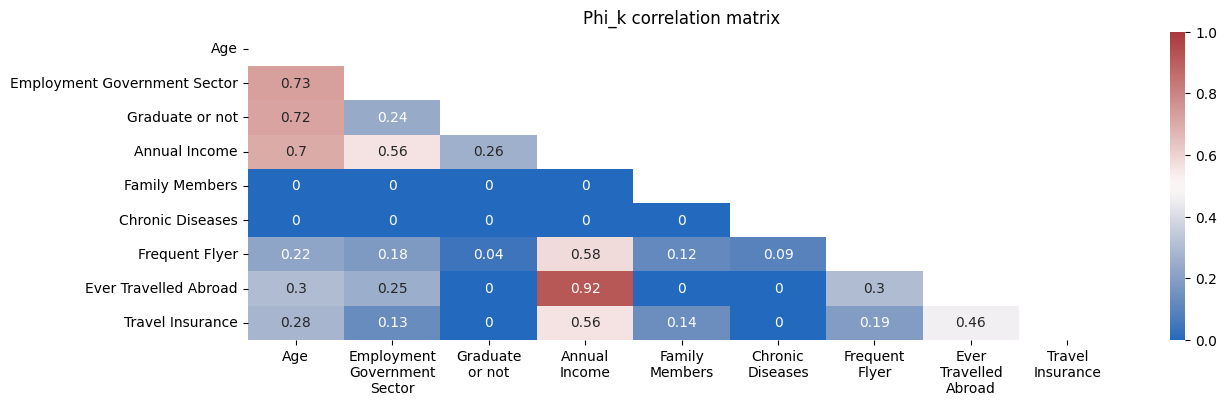

In [34]:
phik_matrix = df_train_eda.phik_matrix(
    interval_cols=["Age", "Annual Income", "Family Members"]
).round(2)

phik_matrix *= 1 + np.diag(np.nan * np.ones(9))

mask = np.triu(np.ones_like(phik_matrix, dtype=bool))
wrapped_labels = [
    "\n".join(textwrap.wrap(label, width=10)) for label in phik_matrix.columns
]

plt.figure(figsize=(14, 4))
sns.heatmap(
    phik_matrix,
    mask=mask,
    annot=True,
    cmap="vlag",
    center=0.5,
    vmin=0,
    vmax=1,
    xticklabels=wrapped_labels,
)

plt.title("Phi_k correlation matrix")

plt.show()

Correlations between Independent variables:

- *Ever Travelled Abroad* and *Annual Income* ~ 0.92: A very high correlation, which suggests that people with higher income are significantly more likely to have traveled abroad.
- *Age* and *Employment Government Sector* ~ 0.73: Indicates that the age of individuals is highly correlated with their employment sector. This could mean older individuals are more likely to work in government jobs.
- *Age* and *Graduate or not* ~ 0.72: Suggests older individuals are more likely to be graduates, possibly reflecting educational trends over time.
- *Age* and *Annual Income* ~ 0.7: Suggests that older individuals tend to have higher income.
- *Frequent Flyer* and *Annual Income* ~ 0.58: Indicates that frequent flying behavior is moderately correlated with income levels, which aligns with expectations (wealthier individuals fly more often).
- *Annual Income* and *Employment Government Sector* ~0.56
- Many features have a correlation of 0, such as *Family Members* with most other variables. This suggests these features are unlikely to contribute meaningful predictive power unless engineered further.

Correlation between target variable **Travel Insurance** and independent variables:

- *Annual Income* ~ 0.56
- *Ever Travelled Abroad* ~ 0.46
- *Age* ~ 0.28

1. Feature Importance & Selection:
- Features with zero correlation (e.g., **Family Members** and **Chronic Diseases**) might not directly impact the target variable **Travel Insurance**, so they could be removed, unless their relationships become meaningful after transformation.
- Features with high correlations with **Travel Insurance** (e.g., **Annual Income**, **Ever Travelled Abroad**, and **Frequent Flyer**) are likely to have high predictive power.

2. Collinearity Between Features:
- **Age**, **Graduate or not**, and **Employment Government Sector** are strongly correlated. This means that:
    - One of the features could be dropped (e.g., keep Employment Government Sector or Age).
    - Features could be combined into new feature (e.g., use PCA or feature aggregation like encoding seniority in government roles).
- Annual Income and Ever Travelled Abroad (0.92): Since these features are almost identical in information, one might suffice for the model, depending on which is more interpretable.

This project's purspose is not to explain but predict if customers could be willing to buy **Travel Insurance** based on other features. As different model are impacted differently by correlated features, decision about feature selection will be done when it will be clear which models will be used.

### 1.7. Statistical Inference

In [35]:
df_train_eda.describe()

,Age,Employment Government Sector,Graduate or not,Annual Income,Family Members,Chronic Diseases,Frequent Flyer,Ever Travelled Abroad,Travel Insurance
count,1079.000000,1079.000000,1079.000000,1.079000e+03,1079.000000,1079.000000,1079.000000,1079.000000,1079.000000
mean,29.731233,0.301205,0.834106,9.296571e+05,4.880445,0.327155,0.231696,0.199259,0.384615
std,2.927709,0.458994,0.372158,3.584663e+05,1.762203,0.469392,0.422111,0.399628,0.486730
min,25.000000,0.000000,0.000000,3.000000e+05,2.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,0.000000,1.000000,6.000000e+05,4.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,0.000000,1.000000,9.000000e+05,5.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,1.000000,1.000000,1.200000e+06,6.000000,1.000000,0.000000,0.000000,1.000000
max,35.000000,1.000000,1.000000,1.800000e+06,9.000000,1.000000,1.000000,1.000000,1.000000


**Target population**: All potential customers of the travel insurance package in the future (beyond the 2019 dataset). These are individuals who share similar characteristics as the customers in the sample data, such as age, employment type, income, etc.
- Person who is from 25 to 35 years old. 
- Living with a family. Family size varies from 2 to 9, on average ~ 5 people. Minimum family size of 2 implies that single person households were not included in initial offering of this Incurance to customers.
- Living in India. As Annual Income is stated in Indian Rupees.
- Having Annual Income higher than average. Average salary in India in 2019 was ~ 200 k Rupees for salaried and ~ 125 k Rupees for self-employed employees annually. Minimum value ~ 300k Rupees of **Annual Income** for this dataset implies that initial offer was made for customers with higher income.

It is however not possible to tell if this type of sample selection was intentional limiting to specific **Age** range, **Family Members** situation and **Annual Income** or just these are Customers from specific company.

## 2. Machine Learning Models

### 2.1. Baseline model. Dummy Classifier

Dummy models for classification are simple models that make predictions without learning any patterns from the input features. They serve as a baseline to compare the performance of more sophisticated models. 

**Core Strategies for Dummy Classification Models**
1. **Most Frequent Class (Majority Class).** The model predicts the class that appears most frequently in the training dataset for all instances.
2. **Stratified Random Guessing.** The model predicts classes randomly but maintains the proportion of classes observed in the training set.
3. **Uniform Random Guessing.** Predicts classes randomly, assigning equal probability to all classes, regardless of their frequency in the dataset.
4. **Constant Class Prediction.** Always predicts a fixed class, which can be user-defined.

As this dataset is imbalanced and target variable has 2 classes, Most Frequent Class and Constant Class Prediction will give same results. Uniform Random Guessing is not suitable because of imbalanced data. Having this in mind - **Stratified** method will be used.

**Next important step is to choose appropriate metric to compare models between each other.**

When dealing with imbalanced binary classification, accuracy can be misleading because it does not take into account the class imbalance. Instead, metrics that focus on the performance of the minority class are better suited for this scenario. The choice of metric depends on specific goals, but the following metrics are commonly used:
- **Precision.** Focuses on how many of the predicted positive samples are truly positive. Use this when false positives are more critical.
- **Recall.** Focuses on how many actual positives are correctly identified. Use this when false negatives are more critical.
- **F1 Score.** It is the harmonic mean of precision and recall. It balances the importance of false positives and false negatives, making it suitable when the cost of these errors is comparable. Use this if the dataset is severely imbalanced and you want the metric to account for class imbalance.
- **PR AUC.** shows the trade-off between Precision and Recall for different classification thresholds. It is especially useful when evaluating classifiers on imbalanced datasets. In imbalanced datasets the majority class can dominate False Positives, making **ROC AUC** look better than it should. On the other hand **PR AUC** focuses only on positive predictions, which gives a more realistic performance measure when positives are rare.

Considering from business perspective, goal is to know which customers would be willing to buy **Travel Insurance** in the future. Knowing this information - targeted marketing could be done to these customers. 

To decide on proper metric it has to be considered importance of False Positives and False Negatives.
- False Positives (FP): You mistakenly assign **not interested in Insurance** customer to the group of **interested in Insurance**.
- False Negatives (FN): You mistakenly assign **intereted in Insurance** customer to the group of **not interested in Insurance**.

As there most likely is a need to find as much as possible customers who would be wiling to order **Travel Insurance**, however at the same time avoid sending unnecessary information to uninterested customers, for evaluation of model quality, balanced metric of **PR AUC** will be used.

In [36]:
dummy_stratified = DummyClassifier(strategy="stratified", random_state=RandomState)
dummy_stratified.fit(X_train, y_train)

y_pred = dummy_stratified.predict_proba(X_train)[:, 1]

print(f"PR AUC: {average_precision_score(y_train, y_pred):.2f}\n")
print(
    classification_report(y_train, dummy_stratified.predict(X_train), zero_division=0)
)

PR AUC: 0.38

              precision    recall  f1-score   support

           0       0.61      0.63      0.62       664
           1       0.37      0.35      0.36       415

    accuracy                           0.52      1079
   macro avg       0.49      0.49      0.49      1079
weighted avg       0.52      0.52      0.52      1079



Results show that Stratified Dummy Classifier has **PR AUC** score of ~ 0.38. This will be baseline for comparing other models.

### 2.2. Machine Learning Models

Various Machine Learning models will be tried out in Cross-validation process. Purpose of this is to pick which model on average performs best with default settings and initial dataset. Models to be tested:
- Logistic Regression
- Support Vector Machines (Linear and radial)
- K-Nearest Neighbours
- Naive Bayes
- Decision Tree
- Random Forest

#### 2.2.1. **Logistic Regression**

A linear model that predicts probabilities for classification tasks using a logistic function.
- **Advantages:** Simple and interpretable. Works well for small to medium-sized datasets with linear separability. Robust to noise when data is well-preprocessed. Computationally efficient.
- **Disadvantages:** Assumes linear relationships between predictors and the log-odds of the target variable. Can underperform when the decision boundary is non-linear. Sensitive to multicollinearity (correlated features).
- **Suitability:** Works best for binary classification with balanced data. Handles moderate-sized datasets effectively with up to 1000 features and samples 10× the number of features for reliable estimates.
- **Sensitivity:** 
    - Target Imbalance: Sensitive; `class_weight='balanced'` should be used for imbalanced datasets. 
    - Duplicated Values: Robust unless duplicates dominate one class.
- **Main Parameters:** 
    - `penalty` (`l2` by default). Regularization type with options: `l1` (lasso), `l2` (ridge), or `elasticnet`. Prevents overfitting.
    - `C` (default = 1.0). Regularization strength, where smaller values increase regularization.
    - `class_weight` (default = None). Adjusts weights inversely proportional to class frequencies.

#### 2.2.2. **Support Vector Machines (SVM)**

Finds the optimal hyperplane that maximizes the margin between classes. Supports linear (`kernel='linear'`) and non-linear (`kernel='rbf'`) decision boundaries.
- **Advantages:** Works well for high-dimensional data. Effective for small to medium-sized datasets. Robust to outliers (with soft margin via `C`).
- **Disadvantages:** Computationally expensive for large datasets. Requires careful parameter tuning (e.g., `C`, `gamma`). Poor performance with noisy or overlapping classes.
- **Suitability:** 
    - Linear SVM: Small to medium datasets with linear boundaries.
    - Radial SVM: Non-linear relationships and small datasets. Up to 10,000 features, up to 1,000–10,000 samples for practical performance.
- **Sensitivity:**
    - Target Imbalance: Use `class_weight='balanced'` for imbalanced classes.
    - Duplicated Values: Can overfit if duplicates dominate one class.
    - Feature Scaling: Mandatory for optimal results.
- **Main Parameters:**
    - `C` (default = 1.0). Controls trade-off between maximizing margin and minimizing misclassification. Smaller values increase regularization.
    - `kernel` (`'rbf'` by default). Function for mapping input space to higher dimensions. Common options: `'linear'`, `'rbf'`, `'poly'`.
    - `gamma` (`scale` by default). Defines the influence of a single training sample for `'rbf'` and `'poly'` kernels. Lower values result in smoother decision boundaries.

#### 2.2.3. **K-Nearest Neighbors (k-NN)**

A non-parametric method that classifies based on the majority vote of the nearest neighbors.
- **Advantages:** Simple and interpretable. Flexible for multi-class problems. No explicit training phase; only requires storing data.
- **Disadvantages:** Computationally expensive for large datasets. Sensitive to feature scaling and irrelevant features. Performance decreases with the curse of dimensionality.
- **Suitability:** Best for small datasets with up to 20 features, and up to 5000 for reasonable speed.
- **Sensitivity:**
    - Target Imbalance. Highly sensitive as nearest neighbors of minority class might be overwhelmed by majority class.
    - Duplicated Values. Robust unless duplicates dominate the nearest neighbors.
- **Main Parameters:**
    - `n_neighbors` (default = 5). Number of neighbors to consider.
    - `metric` (`'minkowski'` by default). Distance metric. Common options: `'euclidean'`, `'manhattan'`.
    - `weights` (`'uniform'` by default). Weighting of neighbors. Options: `'uniform'` (equal weight), `'distance'` (closer neighbors weighted more).

#### 2.2.4. **Naive Bayes**

Probabilistic model based on Bayes' theorem, assuming feature independence.
- **Advantages:** Fast and computationally efficient. Works well with categorical data. Robust to irrelevant features.
- **Disadvantages:** Assumes independence of features, which rarely holds true in real data. Sensitive to zero probabilities for unseen categories (use smoothing).
- **Suitability:** Works well with small datasets having up to 100 features and sample size of 100–10,000. Performs well with categorical or text data (e.g., spam detection).
- **Sensitivity:**
    - Target Imbalance: Use Laplace smoothing to address rare events.
    - Duplicated Values: Robust due to probabilistic nature.
- **Main Parameters:**
    - `alpha` (default = 1.0). Laplace smoothing parameter to handle zero probabilities.
    - Model Type: `GaussianNB` for continuous features, `MultinomialNB` for count-based features, `BernoulliNB` for binary features.

#### 2.2.5. **Decision Tree**

Splits data into branches based on feature thresholds, forming a tree-like structure.
- **Advantages:** Interpretable and intuitive. Handles numerical and categorical data. No need for scaling or preprocessing.
- **Disadvantages:** Prone to overfitting without regularization. Can create biased trees with imbalanced datasets.
- **Suitability:** Best for small to medium datasets with up to 500 features and 1,000–50,000 samples.
- **Sensitivity:**
    - Target Imbalance: Use class weighting or balanced splitting criteria.
    - Duplicated Values: Can lead to biased splits.
- **Main Parameters:**
    - `max_depth` (default = None). Limits the depth of the tree to reduce overfitting.
    - `min_samples_split` (default = 2). Minimum samples needed to split a node.
    - `criterion` (`'gini'` by default). Splitting metric. Options: `'gini'` or `'entropy'`.

#### 2.2.6. **Random Forest**

An ensemble of decision trees trained on different subsets of data and features.
- **Advantages:** Robust to overfitting due to averaging of trees. Handles both numerical and categorical data. Provides feature importance scores.
- **Disadvantages:** Slower training and prediction than single models. Less interpretable than individual trees.
- **Suitability:** Best for medium to large datasets with up to 5,000 features and 1,000–100,000 samples.
- **Sensitivity:**
    - Target Imbalance: Use `class_weight='balanced'` or balanced random forests.
    - Duplicated Values: Generally robust.
- **Main Parameters:**
    - `n_estimators` (default = 100). Number of trees in the forest.
    - `max_features` (default = `'sqrt'`). Number of features to consider for splits.
    - `max_depth` (default = None). Limits tree depth to reduce overfitting.

### 2.3. Model Selection

Pipelines will be constructed for each Model, to ensure proper transformations.

For Tree based models numerical feature scaling is not necessary, however for the workflow simplicity same transformations will be used for all models:
- OneHotEncoder - for categorical variables with `drop="if_binary"`.
- StandartScaler for numerical features.

In [37]:
numerical_features = ["Age", "AnnualIncome", "FamilyMembers"]
categorical_features = [
    "Employment Type",
    "GraduateOrNot",
    "ChronicDiseases",
    "FrequentFlyer",
    "EverTravelledAbroad",
]

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop="if_binary", handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

model_Log_Regression = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            LogisticRegression(class_weight="balanced", random_state=RandomState),
        ),
    ]
)
model_SVM_Linear = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            svm.SVC(
                kernel="linear",
                probability=True,
                class_weight="balanced",
                random_state=RandomState,
            ),
        ),
    ]
)
model_SVM_RBF = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            svm.SVC(
                kernel="rbf",
                probability=True,
                class_weight="balanced",
                random_state=RandomState,
            ),
        ),
    ]
)
model_KNN = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", KNeighborsClassifier(n_neighbors=5)),
    ]
)
model_Naive_Bayes = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", GaussianNB())]
)
model_Decision_Tree = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            DecisionTreeClassifier(class_weight="balanced", random_state=RandomState),
        ),
    ]
)
model_Random_Forest = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            RandomForestClassifier(
                n_estimators=100, random_state=RandomState, class_weight="balanced"
            ),
        ),
    ]
)

For imbalanced data, stratified k-fold cross-validation will be used to maintain class proportions.

In [38]:
kfold = StratifiedKFold(n_splits=10)

results = {
    "PR AUC Mean": [],
    "PR AUC Std": [],
    "Recall Mean": [],
    "Recall Std": [],
}
pr_auc = []

classifiers = [
    "Logistic Regression",
    "Linear Svm",
    "Radial Svm",
    "KNN",
    "Naive Bayes",
    "Decision Tree",
    "Random Forest",
]

models = [
    model_Log_Regression,
    model_SVM_Linear,
    model_SVM_RBF,
    model_KNN,
    model_Naive_Bayes,
    model_Decision_Tree,
    model_Random_Forest,
]

scoring = {"pr_auc": "average_precision", "recall": "recall"}

for m in models:
    cv_result = cross_validate(m, X_train, y_train, cv=kfold, scoring=scoring)
    results["PR AUC Mean"].append(cv_result["test_pr_auc"].mean().round(4))
    results["PR AUC Std"].append(cv_result["test_pr_auc"].std().round(4))
    results["Recall Mean"].append(cv_result["test_recall"].mean().round(4))
    results["Recall Std"].append(cv_result["test_recall"].std().round(4))
    pr_auc.append(cv_result["test_pr_auc"])

model_summary = pd.DataFrame(results, index=classifiers)
pr_auc_df = pd.DataFrame(pr_auc, index=classifiers).T
model_summary

,PR AUC Mean,PR AUC Std,Recall Mean,Recall Std
Logistic Regression,0.6395,0.0654,0.5570,0.0780
Linear Svm,0.6376,0.0679,0.3739,0.1354
Radial Svm,0.6966,0.0778,0.5378,0.0931
KNN,0.6089,0.0514,0.5086,0.0846
Naive Bayes,0.6379,0.0696,0.4196,0.0959
Decision Tree,0.4460,0.0458,0.5349,0.0664
Random Forest,0.6262,0.0693,0.5039,0.0844


In [39]:
fig = px.violin(pr_auc_df, box=True, points="all")
fig.add_hline(
    y=average_precision_score(y_train, y_pred).round(2),
    line_dash="dash",
    line_color="black",
)
fig.add_annotation(
    y=average_precision_score(y_train, y_pred).round(2) - 0.3,
    x=0.5,
    yref="paper",
    text=f"Dummy Classifier PR AUC: {average_precision_score(y_train, y_pred):.2f}",
    showarrow=False,
)

fig.show()

#### Summary

- PR AUC score results suggest that most of the time, models performed better than Dummy Classifier. 
- Best performans was for Radial SVM, Logistic Regression, Linear SVM, Naive Bayes and Random Forest. Modeling results are in general quite close to each other, Standart deviation of model resuls is also important as it shows model stability.
- From business perspective False Negative error (falsly assigning customer who are willing to buy Insurance as the one who will not buy) is slightly more costly (Insurance will not be offered to potential clients). Therefor Recall results are also checked. It shows that best performans is for Logistic Regression, Radial SVM and Decision Tree.
- Eventhough Linear Svm and Naive Bayes showed good results for PR AUC, Recall results are not good.

**Having in mind these results for further steps will be choosen:**
- Logistic Regression - as model with best Recall result
- Radial SVM - as model with best PR AUC result
- Decision Tree - as model with lowest variantion and good Recall result
- Random Forest - as ensemble model

## 3. Feature Enginering

Feature engineering is a process to select and transform variables when creating a predictive model using machine learning or statistical modeling. Feature engineering typically includes feature creation, feature transformation, feature extraction, and feature selection. With deep learning, feature engineering is automated as part of the algorithm learning.

- **Feature creation** refers to the creation of new features from existing data to help with better predictions. Examples of feature creation include: one-hot-encoding, binning, splitting, and calculated features.
- **Feature transformation** and imputation include steps for replacing missing features or features that are not valid. Some techniques include: forming Cartesian products of features, non-linear transformations (such as binning numeric variables into categories), and creating domain-specific features.
- **Feature extraction** involves reducing the amount of data to be processed using dimensionality reduction techniques. These techniques include: Principal Components Analysis (PCA), Independent Component Analysis (ICA), and Linear Discriminant Analysis (LDA). This reduces the amount of memory and computing power required, while still accurately maintaining original data characteristics.
- **Feature selection** is the process of selecting a subset of extracted features. This is the subset that is relevant and contributes to minimizing the error rate of a trained model. Feature importance score and correlation matrix can be factors in selecting the most relevant features for model training.

### 3.1. Adding New Features

From EDA analysis part there are some features which are good candidates for feature enginering:

- Binning Continuous Variables:
    - Create income brackets (low, high).
    - Group age into bins (e.g., young, middle-aged, senior).
- Ratio Features:
    - Income_per_FamilyMember will be created to understand how average per family member income looks like.

In [40]:
def add_features(df):
    df["IncomeBin"] = df["AnnualIncome"].apply(lambda x: 0 if x <= 1300000 else 1)
    df["AgeBin"] = df["Age"].apply(lambda x: 0 if x <= 26 else 2 if x >= 33 else 1)
    df["IncomeFamilyNumber"] = df["AnnualIncome"] / (
        df["FamilyMembers"] + 0.00001
    )  # adding small value to avoid division by 0

    return df


X_train = add_features(X_train)

### 3.2. Transformations and feature selection

For feature transformation - same transformationsas as in baseline model comparison will be used: Scaller for numerical and OneHotEncoder for categorical.

As this dataset is relatively small - no separate feature selection step will be done. The most importat features will be selected as part of Hyperparameter tuning. 

In [41]:
num_features = ["Age", "AnnualIncome", "FamilyMembers", "IncomeFamilyNumber"]
cat_features = [
    "Employment Type",
    "GraduateOrNot",
    "ChronicDiseases",
    "FrequentFlyer",
    "EverTravelledAbroad",
    "IncomeBin",
    "AgeBin",
]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, cat_features),
        ("num", numerical_transformer, num_features),
    ]
)

X_train_p = preprocessor.fit_transform(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_p = pd.DataFrame(X_train_p, columns=feature_names)

Respective transformations are done with train dataset to align with different model requirements.

### 3.3. Hyperparameter tuning

Hyperparameter tuning will be done manually with **GridSearch**.

#### 3.3.1. Logistic Regression

Most important parameters are:
- `C` - Regularization strenth. Smaller values of `C` mean stronger regularization (less complexity, coefficients shrink more). Larger values of `C` mean weaker regularization (higher model flexibility).
- `penalty` - Regularization type. `"l2"`: Ridge regularization (default in Logistic Regression). `"l1"`: LASSO regularization (shrinks some coefficients to zero for feature selection). `"elasticnet"`: Combination of L1 and L2 regularization.
- `solver` - Specifies the optimization algorithm to solve the logistic regression problem. `"liblinear"`: Good for smaller datasets and when using L1 or L2 regularization.

In [42]:
cv = StratifiedKFold(n_splits=5)

param_grid_lg = {
    "C": [0.13, 0.14, 0.15, 0.16, 0.17],
    "penalty": ["l2", "l1"],
}
grid_log_reg = GridSearchCV(
    LogisticRegression(
        class_weight="balanced", solver="liblinear", random_state=RandomState
    ),
    param_grid_lg,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
)
grid_log_reg.fit(X_train_p, y_train)

print("Best Params:", grid_log_reg.best_params_)
print("Best PR AUC Score:", grid_log_reg.best_score_.round(4))

m_Log_Regression = grid_log_reg.best_estimator_
m_Log_Regression.fit(X_train_p, y_train)

model_summary["Hyperparameter Tuning"] = np.nan
model_summary.loc["Logistic Regression", "Hyperparameter Tuning"] = (
    grid_log_reg.best_score_.round(4)
)

Best Params: {'C': 0.16, 'penalty': 'l1'}
Best PR AUC Score: 0.6876


Multiple iterations were applied to find best set of parameters.
- `C = 0.16` indicates that the model is applying stronger regularization, discouraging large coefficients. In this case optimal value  balances regularization and model performance.
- `l1` regularization performs feature selection by shrinking some coefficients to exactly 0, effectively removing less important or redundant features from the model. This suggests that some features were irrelevant or redundant, and the `l1` penalty improved model performance by reducing noise and multicollinearity.
- `PR AUC = 0.6876` suggests moderate performance for this Logistic Regression model. It indicates that while the model is decent at distinguishing the positive class, there is room for improvement.

Best parameters from search results will be used further.

#### 3.3.2. Radial SVM

Most important parameters are:
- `C` - regularization parameter. Balances the trade-off between achieving a low error on the training data and maintaining a smooth decision boundary (generalization). Higher `C` → model tries to fit the training data more closely (risk of overfitting). Lower `C` → model allows more misclassifications but tends to generalize better (risk of underfitting).
- `gamma` - Kernel coefficient. Controls the influence of a single training example. Higher `gamma` → Model tries to fit individual data points more closely (risk of overfitting). Lower `gamma` → Model creates a smoother decision boundary (risk of underfitting).

In [43]:
param_grid_svm = {
    "C": [1.14, 1.15, 1.16, 1.17],
    "gamma": [0.09, 0.1, 0.11, 0.12],
}

grid_svm = GridSearchCV(
    svm.SVC(
        class_weight="balanced",
        probability=True,
        kernel="rbf",
        random_state=RandomState,
    ),
    param_grid_svm,
    scoring="average_precision",
    cv=cv,
    verbose=1,
    n_jobs=-1,
)


grid_svm.fit(X_train_p, y_train)
print("Best Params:", grid_svm.best_params_)
print("Best PR AUC Score:", grid_svm.best_score_.round(4))

m_SVM_RBF = grid_svm.best_estimator_
m_SVM_RBF.fit(X_train_p, y_train)

model_summary.loc["Radial Svm", "Hyperparameter Tuning"] = grid_svm.best_score_.round(4)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Params: {'C': 1.15, 'gamma': 0.11}
Best PR AUC Score: 0.7067


- `C = 1.15` value means moderate level of regularization. A smaller value of `C` enforces more regularization, leading to a simpler decision boundary. A larger value reduces regularization, allowing the model to fit the training data more closely. This value suggests that the model benefits from some flexibility to closely fit the training data without overfitting.
- Small `gamma` result in a smoother decision boundary, where each point has a wider influence. Large gamma values make the model focus more on individual points, leading to a complex decision boundary that may overfit the data. `gamma = 0.11` indicates that the model does not overly focus on individual data points, reducing the risk of overfitting.
- `PR AUC = 0.7067` is higher than in previous Logistic Regression result (`PR AUC = 0.6876`), suggesting that the SVM model performs better in distinguishing the positive class.

#### 3.3.3. Decision Tree

Most important parameters are:
- `max_depth` - Limits the maximum depth of the tree. A deeper tree can capture more complex patterns but may overfit. A shallow tree may underfit by not capturing enough complexity. This is the most critical parameter for controlling overfitting.
- `min_samples_split` - The minimum number of samples required to split an internal node. A higher value forces the tree to stop splitting early, reducing overfitting. Controls tree growth by limiting splits on small sample sizes.
- `min_samples_leaf` - The minimum number of samples required to be at a leaf node. Ensures that leaves contain enough data points, preventing splits that capture noise. Reduces overfitting by avoiding leaves with very few samples.
- `max_features` - Limits the number of features considered when looking for the best split. Reducing `max_features` can introduce randomness and improve generalization. Helps control model complexity and reduce overfitting. Typical Range:
    - `None`: Use all features (default).
    - `"sqrt"`: Use sqrt(total_features), common in ensemble methods like Random Forest.
    - `"log2"`: Use log2(total_features).

In [44]:
param_grid_tree = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 3, 5],
    "min_samples_leaf": [12, 13, 14, 15, 16],
    "max_features": [None, "sqrt", "log2"],
    "max_leaf_nodes": [None, 32, 33, 34, 35, 36],
}

grid_tree = GridSearchCV(
    DecisionTreeClassifier(class_weight="balanced", random_state=RandomState),
    param_grid_tree,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
)

grid_tree.fit(X_train_p, y_train)

print("Best Params:", grid_tree.best_params_)
print("Best PR AUC Score:", grid_tree.best_score_.round(4))

m_Decision_Tree = grid_tree.best_estimator_
m_Decision_Tree.fit(X_train_p, y_train)

model_summary.loc["Decision Tree", "Hyperparameter Tuning"] = (
    grid_tree.best_score_.round(4)
)

Best Params: {'max_depth': None, 'max_features': None, 'max_leaf_nodes': 35, 'min_samples_leaf': 15, 'min_samples_split': 2}
Best PR AUC Score: 0.6911


- `max_depth = None` - The tree is allowed to grow until all leaves are pure or contain fewer than `min_samples_split` samples. No limit on depth ensures the tree can model highly complex patterns if needed. The absence of a depth limit worked well for this dataset, likely because other parameters (e.g., `max_leaf_nodes`, `min_samples_leaf`) are controlling overfitting.
- `max_features = None` - All features are considered for splitting at each node (default behavior). Using all features at each split allows the model to find the most predictive splits, which may have improved performance for this dataset.
- `max_leaf_nodes = 35` The tree is constrained to have a maximum of 35 leaf nodes. This effectively limits the number of splits and controls overfitting. A specific number of leaf nodes strikes a balance between capturing complexity and avoiding overfitting. By capping at 35, the model avoids excessive branching on noisy or redundant features.
- `min_samples_leaf = 15` - A leaf node must have at least 15 samples. Prevents the tree from creating leaves with very few samples, which could lead to overfitting. Larger leaf sizes force the tree to generalize better by ensuring splits occur only on meaningful patterns.
- `min_samples_split = 2` - A node can be split if it contains at least 2 samples. This is the default value and allows the tree to split whenever possible, but other parameters like `max_leaf_nodes` and `min_samples_leaf` act as additional constraints.
- `PR AUC = 0.6911` indicates a good balance between precision and recall.

#### 3.3.4. Random Forest

Most important parameters are:
- `n_estimators` - Number of trees in the forest. More trees generally improve performance by reducing variance but increase computation time.
- `max_depth` - Limits the depth of each tree in the forest. Deeper trees can model more complex patterns but may overfit.
- `min_samples_split` - Minimum number of samples required to split an internal node. Larger values reduce the number of splits, simplifying the model. Reduces overfitting by controlling tree growth.
- `min_samples_leaf` - Minimum number of samples required to be at a leaf node. Larger values prevent the tree from creating leaves with very few samples, reducing overfitting. Encourages generalization by ensuring leaf nodes contain enough data.
- `max_features` - Limits the number of features considered when looking for the best split. Reducing `max_features` can introduce randomness and improve generalization. Helps control model complexity and reduce overfitting. Typical Range:
    - `None`: Use all features (default).
    - `"sqrt"`: Use sqrt(total_features), common in ensemble methods like Random Forest.
    - `"log2"`: Use log2(total_features).

In [45]:
param_grid_forest = {
    "n_estimators": [170, 180, 190],
    "max_depth": [4, 5, 6],
    "min_samples_split": [17, 18, 19],
    "min_samples_leaf": [4, 5, 6, 7],
}

grid_forest = GridSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=RandomState),
    param_grid_forest,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
)

grid_forest.fit(X_train_p, y_train)

print("Best Params:", grid_forest.best_params_)
print("Best PR AUC Score:", grid_forest.best_score_.round(4))

m_Random_Forest = grid_forest.best_estimator_
m_Random_Forest.fit(X_train_p, y_train)

model_summary.loc["Random Forest", "Hyperparameter Tuning"] = (
    grid_forest.best_score_.round(4)
)

Best Params: {'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 18, 'n_estimators': 180}
Best PR AUC Score: 0.7071


- `max_depth = 5` - A depth of 5 indicates that limiting the tree complexity helped reduce overfitting while still capturing enough of the relationships in the data.
- `min_samples_leaf = 6` - Ensuring leaves have at least 6 samples forces the model to generalize, especially for noisy data or imbalanced datasets.
- `min_samples_split = 18` - A node must have at least 18 samples to be eligible for splitting. By requiring more samples per split, the trees are constrained to grow less deeply, resulting in better generalization and reduced overfitting.
- `n_estimators = 180` - The forest is composed of 180 trees. A larger number of trees reduces variance by averaging predictions across more trees.
- `PR AUC = 0.7071` result is similar to other models' results.

#### 3.3.5. Ensemble model. Voting Classifier

The Voting Classifier is an ensemble method that combines predictions from multiple individual models (or "estimators") to make a final prediction. It improves overall performance by leveraging the strengths of each model in the ensemble. There are 2 main ways:

- **Hard Voting (Majority Rule):** Each classifier casts a "vote" for the predicted class. The final prediction is the class with the majority of votes. Best for classification tasks where all models are expected to perform well and have similar accuracies.
- **Soft Voting (Weighted Probabilities):** Each classifier predicts class probabilities, and the final prediction is based on the average of predicted probabilities, weighted if desired. Requires base classifiers to have a predict_proba() method (i.e., support probability estimation). Often performs better than hard voting because it accounts for the confidence of each model.

Logistic Regression, Radial SVM and Decision Tree models with their calculated best parameters will be used in Voting Classifier.

In [46]:
m_Voting = VotingClassifier(
    estimators=[("lr", m_Log_Regression), ("svm", m_SVM_RBF), ("dt", m_Decision_Tree)],
    voting="soft",
    n_jobs=-1,
)

cv_scores_v = cross_validate(
    m_Voting, X_train_p, y_train, cv=kfold, scoring="average_precision"
)

print("PR AUC score:", cv_scores_v["test_score"].mean().round(4))
model_summary.loc["Voting Classifier", "Hyperparameter Tuning"] = (
    cv_scores_v["test_score"].mean().round(4)
)

m_Voting.fit(X_train_p, y_train)

PR AUC score: 0.7042


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.16,
                                                 class_weight='balanced',
                                                 penalty='l1', random_state=198,
                                                 solver='liblinear')),
                             ('svm',
                              SVC(C=1.15, class_weight='balanced', gamma=0.11,
                                  probability=True, random_state=198)),
                             ('dt',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_leaf_nodes=35,
                                                     min_samples_leaf=15,
                                                     random_state=198))],
                 n_jobs=-1, voting='soft')

Voting Classifier `PR AUC = 0.7042` result is very similar to other models. Reason for this may be:

- **Base Models Have Similar Strengths:** If the individual models in the voting classifier have similar `PR AUC` scores and make similar predictions, the ensemble may not add much value.
- **PR AUC Saturation:** If dataset is challenging and the `PR AUC` is already near the achievable maximum for the current data and features, adding an ensemble won't significantly improve results.
- **Dataset Characteristics:** If the dataset lacks enough complexity or variability, even combining models might not offer much improvement over the individual models.

## 4. Model evaluation

### 4.1. Predictions

First - test dataset will be transformed the same way as train dataset.

In [47]:
X_test = add_features(X_test)
X_test_p = preprocessor.transform(X_test)
X_test_p = pd.DataFrame(X_test_p, columns=feature_names)

In [48]:
model_summary_copy = model_summary.copy(deep=True)
model_summary.drop(columns=["Recall Mean", "Recall Std", "PR AUC Std"], inplace=True)
model_summary.drop(index=["Linear Svm", "KNN", "Naive Bayes"], inplace=True)
model_summary["Train"] = np.nan
model_summary["Test"] = np.nan

Predictions on train and test data will be made.

In [49]:
model_list = {
    "Logistic Regression": m_Log_Regression,
    "Radial Svm": m_SVM_RBF,
    "Decision Tree": m_Decision_Tree,
    "Random Forest": m_Random_Forest,
    "Voting Classifier": m_Voting,
}

for key, m in model_list.items():
    model_summary.loc[key, "Train"] = average_precision_score(
        y_train, m.predict_proba(X_train_p)[:, 1]
    ).round(4)
    model_summary.loc[key, "Test"] = average_precision_score(
        y_test, m.predict_proba(X_test_p)[:, 1]
    ).round(4)

In [50]:
model_summary = model_summary.reset_index()
model_summary = model_summary.rename(
    columns={"PR AUC Mean": "Initial CV", "index": "Model"}
)
model_summary_melted = model_summary.melt(
    id_vars="Model",
    value_vars=["Initial CV", "Hyperparameter Tuning", "Train", "Test"],
    var_name="Step",
    value_name="PR AUC",
)

In [51]:
fig = px.bar(
    model_summary_melted,
    x="Step",
    y="PR AUC",
    color="Model",
    barmode="group",
    height=400,
    title="PR AUC scores during different modeling steps",
    text_auto=True,
)
fig.show()
model_summary

,Model,Initial CV,Hyperparameter Tuning,Train,Test
0,Logistic Regression,0.6395,0.6876,0.6904,0.7783
1,Radial Svm,0.6966,0.7067,0.7466,0.7645
2,Decision Tree,0.4460,0.6911,0.7618,0.7986
3,Random Forest,0.6262,0.7071,0.7845,0.7993
4,Voting Classifier,NaN,0.7042,0.7560,0.8127


- All models except the Voting Classifier (where Cross Validation isn’t applicable) show an improvement in performance after hyperparameter tuning. This highlights the importance of tuning for better results.
- The test scores are consistently higher than train scores. This could be due to easier patterns in the test set or overestimation during validation.
- Radial Svm had best result with default parameters during Cross Validation step, however parameter tuning did not add much improvement here.
- On the other hand - Decision Tree had worst result in the start, and it was significantly improved during parameter tuning.
- The Voting Classifier has the highest test score (0.8127), suggesting that combining models helps achieve better generalization. It benefits from leveraging the strengths of its base models.

One of the reasons for better performance on test dataset compared to train dataset can be that after train - test split, duplicated values were cleaned from train dataset, however they were left in test dataset. To check this - test dataset will be cleaned from duplicates the same way as train, and transformations and prediction steps will be repeated.

In [ ]:
df_test_d = df_test.copy(deep=True)
df_test_d.drop_duplicates(keep="first", inplace=True)

X_test_d = df_test_d.drop(columns=["TravelInsurance"])
y_test_d = df_test_d["TravelInsurance"]

X_test_d = add_features(X_test_d)
X_test_d_p = preprocessor.transform(X_test_d)
X_test_d_p = pd.DataFrame(X_test_d_p, columns=feature_names)

model_summary["Test without duplicates"] = np.nan

for key, m in model_list.items():
    m.fit(X_train_p, y_train)
    model_summary.loc[model_summary.Model == key, "Test without duplicates"] = (
        average_precision_score(y_test_d, m.predict_proba(X_test_d_p)[:, 1]).round(4)
    )

model_summary

,Model,Initial CV,Hyperparameter Tuning,Train,Test,Test without duplicates
0,Logistic Regression,0.6395,0.6876,0.6904,0.7783,0.7615
1,Radial Svm,0.6966,0.7067,0.7466,0.7645,0.7505
2,Decision Tree,0.4460,0.6911,0.7618,0.7986,0.7843
3,Random Forest,0.6262,0.7071,0.7845,0.7993,0.7862
4,Voting Classifier,NaN,0.7042,0.7560,0.8127,0.7985


Test without duplicates results are consistently ~1.5 - 2 % lower than original Test dataset results. This shows that none of the models were able to "learn" or "guess correctly" duplicated patterns, and their performans results are based on how good they were able to generalized data.

Having in mind nature of this dataset: many binary categorical features, binned numerical continues features - duplicates are expexted and modeling without duplicate removal could be one of the next steps to see if this could improve model performance.

### 4.2. Feature importance

For Logistic Regression, Decision Tree and Random Forest Models feature importance will be checked.

#### 4.2.1. Logistic Regression

In [53]:
feature_names = X_train_p.columns

m_Log_Regression.fit(X_train_p, y_train)
coefficients = m_Log_Regression.coef_[0].round(3)
intercept = m_Log_Regression.intercept_[0].round(3)

lr_coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
lr_coef_df["Importance"] = lr_coef_df["Coefficient"].abs()
lr_coef_df = lr_coef_df.sort_values(by="Importance", ascending=False)

print("Intercept:", intercept)
print("\nFeature Importance Ranking:")
print(lr_coef_df)

Intercept: -0.035

Feature Importance Ranking:
                                              Feature  Coefficient  Importance
5                                    cat__IncomeBin_1        2.200       2.200
7                                       cat__AgeBin_1       -0.455       0.455
11                                 num__FamilyMembers        0.193       0.193
9                                            num__Age        0.185       0.185
10                                  num__AnnualIncome        0.085       0.085
2                              cat__ChronicDiseases_1       -0.059       0.059
0   cat__Employment Type_Private Sector/Self Employed        0.000       0.000
1                              cat__GraduateOrNot_Yes        0.000       0.000
3                              cat__FrequentFlyer_Yes        0.000       0.000
4                        cat__EverTravelledAbroad_Yes        0.000       0.000
6                                       cat__AgeBin_0        0.000       0.000
8    

- Logistic Regression model has parameter `penalty="l1"` which enforces feature selection. That is why only 6 features have non 0 coefficients.
- Results show that most positive impact has IncomeBin_1 which is **Annual Income** with 1.3 m and more.
- Highest negative impact is by AgeBin_1 which is **Age** between 27-32 (included). From EDA part it was visible that this age range has lower tendency of buying **Travel Insurance**.
- From EDA **Frequent Flyer** and **Ever Travelled Abroad** showed promising behaviour toward **Travel Insurance** (Frequent Flyer - yes, and Ever Travelled Abroad - yes: were buying Travel Insurance more frequently). However due to correlation with **Annual Income** and feature selection startegy, these features were removed and features related to **Annual Income** were kept.

#### 4.2.2. Decision Tree

In [54]:
feature_importances_tree = m_Decision_Tree.feature_importances_

importance_tree_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances_tree}
)
importance_tree_df = importance_tree_df.sort_values(by="Importance", ascending=False)

print(importance_tree_df)

                                              Feature  Importance
5                                    cat__IncomeBin_1    0.465266
11                                 num__FamilyMembers    0.234839
9                                            num__Age    0.131288
12                            num__IncomeFamilyNumber    0.088619
10                                  num__AnnualIncome    0.038214
1                              cat__GraduateOrNot_Yes    0.023126
0   cat__Employment Type_Private Sector/Self Employed    0.012287
3                              cat__FrequentFlyer_Yes    0.006361
2                              cat__ChronicDiseases_1    0.000000
4                        cat__EverTravelledAbroad_Yes    0.000000
6                                       cat__AgeBin_0    0.000000
7                                       cat__AgeBin_1    0.000000
8                                       cat__AgeBin_2    0.000000


- Eventhough `max_features=None` means that number of features used in model is not limited, some features have zero importance.
- Most important feature is IncomeBin_1.
- **Age** bining was not needed for this model, as all bins have importance of 0 compared to non zero value of **Age** feature.
- Next main important features: **FamilyMembers** and other features related to **AnnualIncome**.

#### 4.2.3. Random Forest

In [55]:
feature_importances_forest = m_Random_Forest.feature_importances_

importance_forest_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances_forest}
)
importance_forest_df = importance_forest_df.sort_values(
    by="Importance", ascending=False
)

print(importance_forest_df)

                                              Feature  Importance
10                                  num__AnnualIncome    0.261994
5                                    cat__IncomeBin_1    0.224333
11                                 num__FamilyMembers    0.098766
12                            num__IncomeFamilyNumber    0.096445
4                        cat__EverTravelledAbroad_Yes    0.078859
9                                            num__Age    0.078641
8                                       cat__AgeBin_2    0.057451
7                                       cat__AgeBin_1    0.052668
3                              cat__FrequentFlyer_Yes    0.012776
0   cat__Employment Type_Private Sector/Self Employed    0.010840
1                              cat__GraduateOrNot_Yes    0.010238
6                                       cat__AgeBin_0    0.008791
2                              cat__ChronicDiseases_1    0.008197


- Similarly like in Decision Tree model - most important features are related to one or other form of **AnnualIncome**.
- Also important are **FamilyMembers** and **Age**.
- In this model all features have non zero importance.

#### 4.2.4. Feature importance Summary

While feature importanc vary depending on the model, there are 4 common features in top 6 of each model: 
- `AnnualIncome` - people with higher **Annual Income** tend to buy **Travel Insurance** more.
- `IncomBin_1` - same resul as from `AnnualIncome`.
- `FamilyMembers` - people with bigger families tend to buy **Travel Insurance** more.
- `Age` - relatively older people tend to buy **Travel Insurance** more.

This result corresponds with insights observed in EDA part.

### 4.3. Confusion Matrix and Classification Report

In [56]:
print("Logistic Regression")
print(
    classification_report(y_test, m_Log_Regression.predict(X_test_p), zero_division=0)
)
print(
    "Confusion matrix\n", confusion_matrix(y_test, m_Log_Regression.predict(X_test_p))
)

Logistic Regression
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       256
           1       0.68      0.68      0.68       142

    accuracy                           0.77       398
   macro avg       0.75      0.75      0.75       398
weighted avg       0.77      0.77      0.77       398

Confusion matrix
 [[211  45]
 [ 45  97]]


In [57]:
print("Radial SVM")
print(classification_report(y_test, m_SVM_RBF.predict(X_test_p), zero_division=0))
print("Confusion matrix\n", confusion_matrix(y_test, m_SVM_RBF.predict(X_test_p)))

Radial SVM
              precision    recall  f1-score   support

           0       0.83      0.89      0.85       256
           1       0.76      0.66      0.71       142

    accuracy                           0.81       398
   macro avg       0.79      0.77      0.78       398
weighted avg       0.80      0.81      0.80       398

Confusion matrix
 [[227  29]
 [ 48  94]]


In [58]:
print("Decision Tree")
print(classification_report(y_test, m_Decision_Tree.predict(X_test_p), zero_division=0))
print("Confusion matrix\n", confusion_matrix(y_test, m_Decision_Tree.predict(X_test_p)))

Decision Tree
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       256
           1       0.62      0.69      0.66       142

    accuracy                           0.74       398
   macro avg       0.72      0.73      0.72       398
weighted avg       0.75      0.74      0.74       398

Confusion matrix
 [[197  59]
 [ 44  98]]


In [59]:
print("Random Forest")
print(classification_report(y_test, m_Random_Forest.predict(X_test_p), zero_division=0))
print("Confusion matrix\n", confusion_matrix(y_test, m_Random_Forest.predict(X_test_p)))

Random Forest
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       256
           1       0.79      0.66      0.72       142

    accuracy                           0.82       398
   macro avg       0.81      0.78      0.79       398
weighted avg       0.81      0.82      0.81       398

Confusion matrix
 [[231  25]
 [ 48  94]]


In [60]:
print("Voting Classifier")
print(classification_report(y_test, m_Voting.predict(X_test_p), zero_division=0))
print("Confusion matrix\n", confusion_matrix(y_test, m_Voting.predict(X_test_p)))

Voting Classifier
              precision    recall  f1-score   support

           0       0.82      0.89      0.86       256
           1       0.77      0.65      0.71       142

    accuracy                           0.81       398
   macro avg       0.80      0.77      0.78       398
weighted avg       0.80      0.81      0.80       398

Confusion matrix
 [[228  28]
 [ 49  93]]


Results show each of the models ability to classify.
- Logistic Regression made same amout of both mistakes.
- SVM was very good at correctly classifying Group 0 (Precision, avoiding False Positive)
- Decision Tree is good at classifying Group 1 (Recall, avoiding False Negative)
- Random Forest was even better than SVM with Group 0 classification.
- Voting Classifier was close, but did not got the best score for separate Groups compared to base models.


### 4.4. Simulation

When having business formulated problem like here: How many people would be wiling ot buy **Travel Insurance**, corect answer not always is obvious. Model provides best results based on chosen metric. However without knowing the **price** of each error: False Positive and False Negative it is difficult to decide on threshold which should be used in model.

For this purpose - simulation with the best model - Voting Classifier will be done to visualise how Precision (focus to minimize False positive), Recall (minimize False Negative) and f1 look like at different threshold.

When evaluating a classification model, the threshold determines the cutoff probability above which a sample is classified as positive (1) and below which it is classified as negative (0). Changing the threshold affects the balance between different metrics, such as Precision, Recall, and F1-Score.

In [61]:
thresholds = np.linspace(0, 1, 50)

precision_scores = []
recall_scores = []
f1_scores = []

y_proba = m_Voting.predict_proba(X_test_p)[:, 1]
pr_auc = average_precision_score(y_test, y_proba)

for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)

    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

metrics_df = pd.DataFrame(
    {
        "Threshold": thresholds,
        "Precision": precision_scores,
        "Recall": recall_scores,
        "F1-Score": f1_scores,
    }
)

In [62]:
metrics_long_df = metrics_df.melt(
    id_vars=["Threshold"],
    value_vars=["Precision", "Recall", "F1-Score"],
    var_name="Metric",
    value_name="Value",
)

fig = px.line(
    metrics_long_df,
    x="Threshold",
    y="Value",
    color="Metric",
    title=f"Metrics vs Threshold (PR AUC: {pr_auc:.4f})",
    labels={"Value": "Metric Value"},
    height=400,
)

fig.add_vline(x=0.5, line_dash="dash", line_color="black")
fig.add_annotation(
    x=0.5,
    y=1.1,
    yref="paper",
    text=f"Default Threshold (0.5)",
    showarrow=False,
)

fig.show()

- Maximum of F1-score at (~ 0.60 - 0.70 threshold) is the area were Precision and Recall are most balanced.
- At threshold ~0.40 Precision and Recall are almost equal, meaning there is relatively same percentage of False Positive and False Negative errors.

In [63]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

fig = px.line(
    x=recalls,
    y=precisions,
    height=450,
    width=500,
    title="Precision-Recall Curve",
    labels={"x": "Recall", "y": "Precision"},
)

fig.add_hline(y=sum(y_test) / len(y_test), line_dash="dash", line_color="black")
fig.add_annotation(
    x=0.3,
    y=sum(y_test) / len(y_test) - 0.3,
    yref="paper",
    text=f"No Skill Baseline",
    showarrow=False,
)

fig.show()

- On the left-hand side of the Precision - Recall  Curve: high thresholds, the model predicts fewer samples as positive but is very precise in doing so.
- On the right-hand side of the Precision - Recall Curve: low thresholds, the model predicts more samples as positive, but its Precision suffers due to the inclusion of more false positives.

## 5. Summary

- EDA is important in understanding data and observing patterns and potential relationships.
- Metric choice matters a lot. Wrong metric can lead to model generalization on the wrong target. This is especially important with imbalanced datasets. For example model can learn to predict Target group - 0 better, if used metric is accuracy. Having this in mind PR AUC metric was used in this work which balances trade - off between precision and recall.
- Analyzed various models like: Logistic regression, SVM, K-nearest neighbours, Naive Bayes, Decision Tree, Random Forest. 
- From PR AUC and Recall results some models were selected for further analysis and hyperparameter tuning.
- Hyperparameter tuning is important step of modeling, as it can significantly improve results (e.g. Decision Tree in this project). With hyperparameter tuning it is possible to make model either more specific (too specific - risk of overfit) or make better at generalising (too generalized - risk of underfit). 
- Ensemble models tend to provide better results as they can utilize strong sides of each of base model used in ensemble. This is specifically valid when base models are of different types.
- Changing threshold, model can be adjusted to business needs e.g. prioritizing one type of error over the other.

## 6. Suggestions for additional analysis and improvement

- Try models on full train dataset without duplicate removal to see if that can improve performance.
- Use random search for finding best hyperparameters as this may improve results compare to grid search.
- Try models which were not used, to see how they perform after hyperparameter tuning and in the ensemble.
- Try modeling without engineered features.
- Create additional engineered features (e.g. interaction between features) and try models with them.